In [5]:
import pandas as pd
import os
import numpy as np
import timeit
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

start = timeit.default_timer()

In [6]:
# Load data
file = os.path.join('C:/Users/LOX/Desktop/CLB/test/Taille', 'mean_std.csv')
data = pd.read_csv(file, dtype={'Taille' : float, 'Appli_origine' : str, 'mean' : float, 'std' : float, 'sem' : float}, na_values = '')

# Taille : m -> cm
data["Taille"] = data["Taille"] *100

### Intervalles Âge



In [7]:
# //// Intervalles Age
age20 = list(range(20 *365)) # Croissance ~ de 0 à 20 ans
age20_40 = list(range((20 *365), (40 *365))) # Stagnation de 0 à 40 ans 
age40_70 = list(range((40 *365), (70 *365))) # Diminution taille à partir de 40 ans
age70plus = list(range((70 *365) , (110 *365)))

# //// Separation en groupe selon les intervalles d'age
data20 = data[data['age_at_entry'].isin(age20)]
data20.to_csv("data20.csv", index=False)
data20_40 = data[data['age_at_entry'].isin(age20_40)]
data40_70 = data[data['age_at_entry'].isin(age40_70)]
data70 = data[data['age_at_entry'].isin(age70plus)]

Distribution des patients dans les différents groupes

|Période|Intervalle (ans)|Effectif|
|:-|:-:|:-:|
|Enfant / Adolescent|[0-20]|105239|
|Jeune Adulte|[20-40]|35848|
|Adulte|[40-70]|229963|
|Seniors|[70-110]|76693|

**Total** : 447 743 lignes.

Quelques *outliers* se remarquent :

    


In [8]:
# //// Some weird values
data_outliers00 = data[data['age_at_entry'] < 0] # age < 0
data_outliers01 = data[data['Taille'] > 220]     # Taille > 2.5 m

print(data_outliers00)
print(data_outliers01)

            IPPR  age_at_entry  age_at_diag  ...  Appli      mean       std
33460    4551728        -16945        20658  ...    CRC  1.614615  0.008593
34467    2570704        -16191        20956  ...    CRC  1.800000       NaN
190905  44202662          -177         5203  ...    EVO  1.398636  0.637658
236976   1010967          -366         1204  ...    EVO  0.926222  0.139859
272814   5886934          -109         2405  ...    EVO  1.225244  0.104577
281116  14101197           -61          379  ...    EVO  0.908776  0.136867
296918  79217370          -458          844  ...    EVO  0.919833  0.124254
297850   1104440          -153          912  ...    EVO  0.820000  0.171270
314701  14123677           -90         1305  ...    EVO  0.490909  0.368279
315351  47136365          -122          101  ...    EVO  0.836250  0.207704
366620  31462451          -329         2890  ...    EVO  1.146316  0.169704

[11 rows x 8 columns]
            IPPR  age_at_entry  age_at_diag  ...  Appli      mean

### Boxplots : Taille du patient ~ Tranche d'Âge

Text(0.5, 1.0, "Taille du patient ~ Tranche d'Âge")

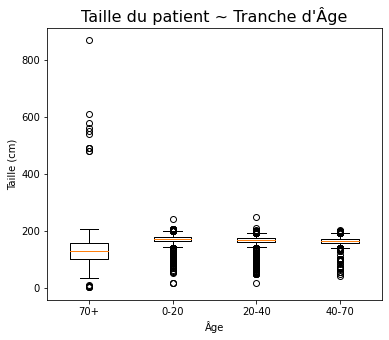

In [9]:
# Data used for the boxplpots
plt.figure(figsize=(6, 5))
data_bxplt = [data20["Taille"], data20_40["Taille"], data40_70["Taille"], data70["Taille"]]
labels={'0-20', '70+', '40-70', '20-40'}

# boxplot w/o ylim (outliers are visible)
plt.boxplot(data_bxplt, labels=labels)
plt.ylabel("Taille (cm)")
plt.xlabel("Âge")
plt.title("Taille du patient ~ Tranche d'Âge", fontsize=16)

On recommence en supprimant les valeurs de taille > 300 cm

Text(0.5, 1.0, 'Boxplot sans les outliers')

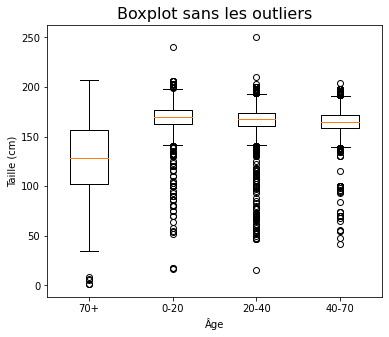

In [10]:
# boxplot w/o outliers
data20 = data20[data20["Taille"] < 300]
data_bxplt = [data20["Taille"], data20_40["Taille"], data40_70["Taille"], data70["Taille"]]
plt.figure(figsize=(6, 5))
plt.boxplot(data_bxplt, labels=labels)
plt.ylabel("Taille (cm)")
plt.xlabel("Âge")
plt.title("Boxplot sans les outliers", fontsize=16)

### Histogrammes : Taille du patient ~ Tranche d'Âge

Text(0.5, 0.95, "Histogrammes : Taille du patient ~ Tranche d'Âge")

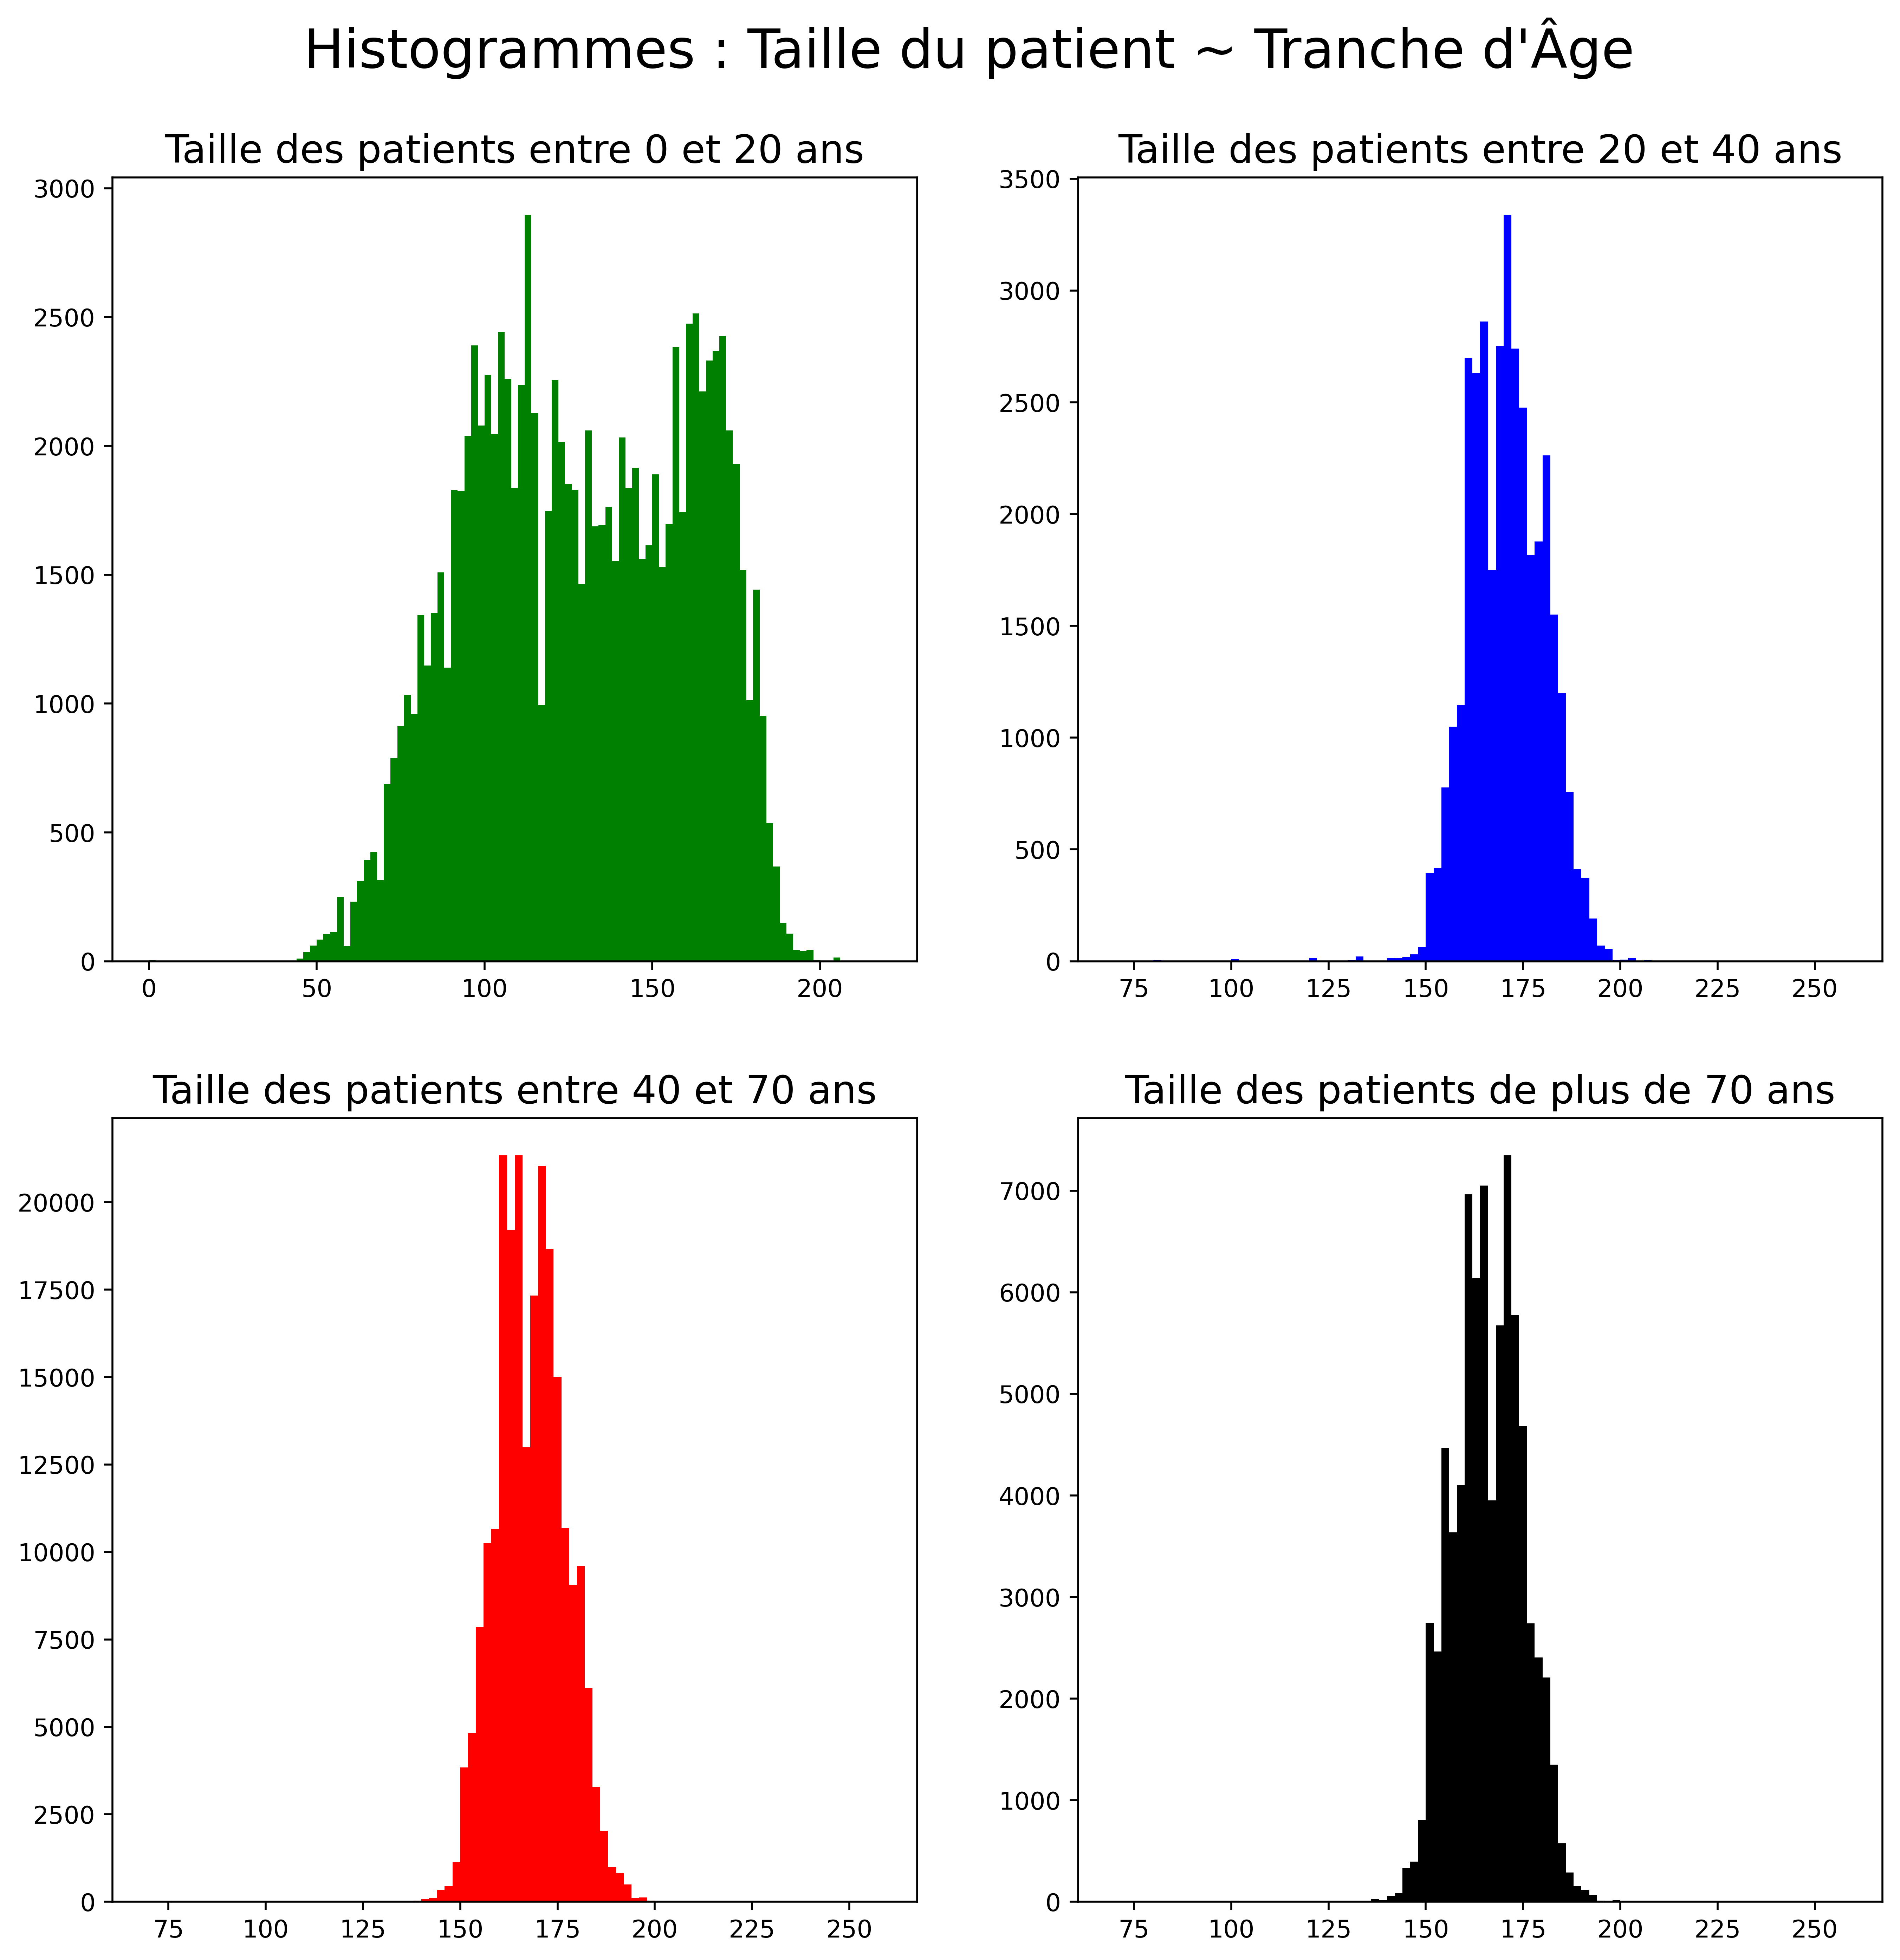

In [31]:
# [00-20] range histogram
plt.figure(figsize=(13, 13), dpi=500)
plt.subplot(2,2,1)
bins = np.arange(0, 220, 2)
plt.hist(data20['Taille'], bins = bins, color='g') 
plt.title('Taille des patients entre 0 et 20 ans', fontsize=16)

# [20-40] range histogram
bins = np.arange(70, 260, 2)
plt.subplot(2,2,2)
plt.hist(data20_40['Taille'], bins = bins, color='b') 
plt.title('Taille des patients entre 20 et 40 ans', fontsize=16)


# [40-70] range histogram
plt.subplot(2,2,3)
plt.hist(data40_70['Taille'], bins = bins, color='r') 
plt.title('Taille des patients entre 40 et 70 ans', fontsize=16)


# [70-110] range histogram
plt.subplot(2,2,4)
plt.hist(data70['Taille'], bins = bins, color='k')
plt.title('Taille des patients de plus de 70 ans', fontsize=16)
plt.suptitle("Histogrammes : Taille du patient ~ Tranche d'Âge", fontsize = 22, y = 0.95)

In [ ]:
stop = timeit.default_timer()
print()
print('Time:  ', str(round(stop - start, 4)), 's\n\t' + str(round((stop - start) / 60, 4)) + ' m ')
